# **Import libraries**

In [1]:
import csv
import numpy as np
import random

# **Personalized functions** 

In [2]:
def hasNumber(stringVal) :
  return any(elem.isdigit() for elem in stringVal)

In [3]:
def getDigit(stringVal) :
  onlyDigit = ''
  for i in stringVal :
    if (i.isdigit()) :
      onlyDigit += i
  return onlyDigit

In [4]:
def changeToNUM(measurement_list) :
  new_measurement_list = []
  for j in measurement_list : #measure
    if (hasNumber(j) == False) : #숫자가 하나도 없고 전부 문자열인 경우
      new_measurement_list.append(0)
    elif (j == '') : #빈 값인 경우 읽기 때문에 0으로 변경해줌
      new_measurement_list.append(0)

    else : #'1 1/2 oz' 형식으로 되어있음 따라서 공백으로 자르고 처리
      slice_str = []
      slice_str = j.split()
      total_val = 0
        
      for n in slice_str : #잘라진 '1' '1/2' 'oz' 처리
        if (n.isalpha()) :
          pass
        else :
          if (n.find('/') == -1) : #그냥 숫자인 경우
            num_tmp = getDigit(n)
            if (num_tmp == '') :
              num_tmp = 0
            total_val += int(num_tmp)
          else : # 1/2 인 경우
            idx = n.find('/')
            divide_val = int(n[:idx]) / int(n[idx+1:])
            total_val += divide_val
      new_measurement_list.append(total_val)
  return new_measurement_list

# **Read data from csv and pre-process data**

# **Label and ingredient set**

In [5]:
label_set = []
ingredient = []

f = open('mr-boston-flattened.csv','r')
rdr = csv.reader(f)

first_line_pass = 0
line_count = 0
for line in rdr:
  if (first_line_pass == 0) :
    first_line_pass += 1
    pass
  else :
    line_count += 1
    label_set.append(line[1])
    
    for i in range(3,15,2) :
      ingredient.append(line[i])

f.close()

label_set = set(label_set)
label_set = list(label_set)

#add wrong label
label_set.append("Wrong")

ingredient = set(ingredient)
ingredient = list(ingredient)

print("line len ", line_count)
print("label len", len(label_set))
print("label info :",label_set)
print("ingredient len", len(ingredient))

line len  990
label len 12
label info : ['Whiskies', 'Rum', 'Gin', 'Shooters', 'Vodka', 'Cordials and Liqueurs', 'Rum - Daiquiris', 'Brandy', 'Non-alcoholic Drinks', 'Tequila', 'Cocktail Classics', 'Wrong']
ingredient len 688


In [6]:
print(label_set)
print(label_set.append('Wrong'))

['Whiskies', 'Rum', 'Gin', 'Shooters', 'Vodka', 'Cordials and Liqueurs', 'Rum - Daiquiris', 'Brandy', 'Non-alcoholic Drinks', 'Tequila', 'Cocktail Classics', 'Wrong']
None


In [7]:
label = ['' for i in range(line_count)]
label_idx = [0 for i in range(line_count)]
ing = [[0 for col in range(len(ingredient))] for row in range(line_count)]

In [8]:
f = open('mr-boston-flattened.csv','r')
rdr = csv.reader(f)

first_line_pass = 0
line_count = 0
for line in rdr :
  if (first_line_pass == 0) :
    first_line_pass += 1
    pass
  else :

    #변수 초기화
    measurement_list = [] 
    ingred_idx = 3 #용량에 mapping 되는 ingredient idx
    
    for i in range(2,14,2) : #각 row에 measurement 뽑아서 list에 넣기
      measurement_list.append(line[i])

    #ingredient string 을 숫자만 남김
    new_measurement_list = changeToNUM(measurement_list)
    
    #전체 용량 계산하는 부분 필요한 경우 다시 활성화
    #total_measurement_value = sum(new_measurement_list)

    #칵테일 라벨
    label[line_count] = line[1]
    label_idx[line_count] = label_set.index(line[1])

    #숫자로 변환한 것들에 대응하는 재료를 전체 ingredient 리스트에서 해당 하는 인덱스 찾은 후 위치에 값 설정하기
    for j in new_measurement_list :
      if (line[ingred_idx] != '') :
        ing_measure_pair = {line[ingred_idx] : j}
        idx = ingredient.index(line[ingred_idx])
        ing[line_count][idx] = j
      ingred_idx += 2

    line_count += 1 #line idx 역할

f.close()

# **See the ingredient list**

In [9]:
# for i in ing :
#   print(i)
# print("ing row num",len(ing))
# print("ing col num",len(ing[0]))

# **See the label list**

In [10]:
# for i in label :
#   print(i)

# print("label row num",len(label))

# **Random Data Generator**

In [11]:
#RandomGenerateNum = 1000
def Random_Data_Generator(RandomGenerateNum):
    for i in range(RandomGenerateNum):
        generated_recipe = [] # 추가할 wrong label 레시피
        relation = np.zeros(len(ing[0]))
        ingredient_index = random.randrange(0, len(ing[0]) - 1)
        generated_recipe = np.zeros(len(ing[0]))
        label.append('Wrong')
        label_idx.append(label_set.index('Wrong'))
        for _ in range (random.randrange(2,5)):
            generated_recipe[ingredient_index] = round(random.randint(1,10) * 0.2, 1)
            for j in range (len(ing)):
                if ing[j][ingredient_index] != 0:
                    for t in range(len(ing[0])):
                        if ing[j][t] != 0:
                            relation[t] += 1
            ingredient_index = np.argmin(relation)
        # print(generated_recipe)
        ing.append(generated_recipe)



# **Data Shuffling**

In [12]:
import random

def Data_Shuffle():
    random.Random(4).shuffle(ing)
    random.Random(4).shuffle(label_idx)
    random.Random(4).shuffle(label)
    print("데이터: ",np.shape(ing))
    print("label:", np.shape(label_idx))


# **Make Model**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def model_initialize():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=len(ing[0])))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_set), activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# **Training**

In [14]:
from keras.callbacks import EarlyStopping
from keras import utils as np_utils
def Train_Dataset(model):
    one_hot_labels = np_utils.np_utils.to_categorical(label_idx, num_classes=len(label_set))
    train_size = int(len(label) * 0.8)
    train_x = np.array(ing[:train_size])
    train_y = np.array(one_hot_labels[:train_size])
    test_x = np.array(ing[train_size:])
    test_y = np.array(one_hot_labels[train_size:])
    model.fit(
        train_x, train_y,
        epochs=10, batch_size=32,
        )
    score = model.evaluate(test_x, test_y, batch_size=32)
    print(score)
    return score


# **Plot Accuracy**


In [15]:
test_num = 100
score_array = np.zeros((test_num, 2))
for i in range(test_num):
    model = model_initialize()
    Random_Data_Generator(10)
    Data_Shuffle()
    score_array[i] = Train_Dataset(model)


데이터:  (1000, 688)
label: (1000,)
Epoch 1/10
25/25 [==============================] - 1s 3ms/step - loss: 0.5657 - accuracy: 0.1437
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.2475
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3220 - accuracy: 0.3013
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2994 - accuracy: 0.3313
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2606 - accuracy: 0.3825
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2459 - accuracy: 0.4038
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2362 - accuracy: 0.4487
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.4775
Epoch 9/10
25/25 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.5050
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1350 - accur

[0.625      0.58415842 0.68137252 0.66504854 0.625      0.72857141
 0.7028302  0.55140185 0.49537036 0.78440368 0.79545456 0.58558559
 0.6160714  0.59292036 0.69736844 0.72173911 0.67672414 0.61965811
 0.71610171 0.61764705 0.625      0.62396693 0.6557377  0.75609756
 0.68951613 0.63599998 0.66269839 0.7480315  0.71875    0.66279072
 0.72692305 0.69083971 0.67803031 0.71428573 0.76119405 0.7037037
 0.62867647 0.73722625 0.70652175 0.75899279 0.6857143  0.80141842
 0.65140843 0.73076922 0.68055558 0.67241377 0.73630136 0.70748299
 0.6891892  0.76174498 0.70666665 0.73509932 0.71052629 0.64379084
 0.68181819 0.83225805 0.73076922 0.71019107 0.72468352 0.77987421
 0.77812499 0.79503107 0.75617284 0.73926383 0.74695122 0.78484851
 0.74698794 0.75748503 0.72023809 0.72485209 0.7647059  0.79532164
 0.77034885 0.78612715 0.75       0.73142856 0.81534094 0.7824859
 0.74719101 0.85195529 0.74444443 0.79281765 0.84340662 0.80874318
 0.74184781 0.69459462 0.75537634 0.76203209 0.79787236 0.777777

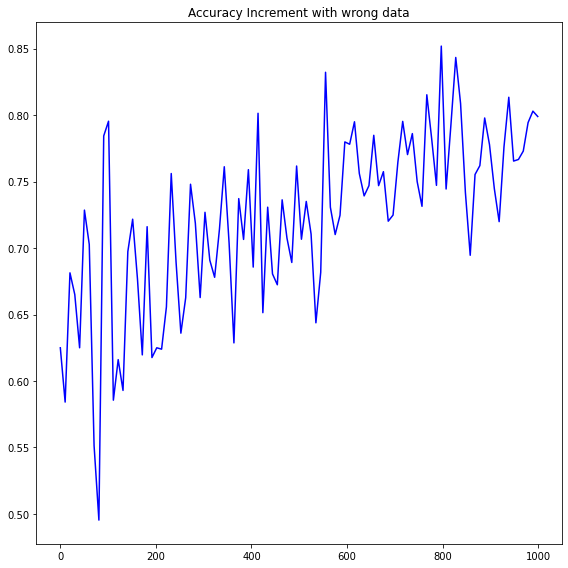

In [18]:
import matplotlib.pyplot as plt
print(np.transpose(score_array)[1])
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,999, test_num), np.transpose(score_array)[1], '-', color = 'blue')

plt.title('Accuracy Increment with wrong data')

plt.tight_layout()
plt.show()



# **View Evaluation**

In [ ]:
s_idx = 100 # 검사 하고 싶은 index 넣기

result = model.predict(test_x)
for idx in range(s_idx, len(test_x)):
    print("ingredients---------------")
    for i, measure in enumerate(test_x[idx]):
        if measure != 0:
            print(ingredient[i], end=",")
    print("")
    idxs = np.argsort(result[idx])
    print("=> 1: ",label_set[idxs[-1]], "2: ", label_set[idxs[-2]], "3: ",label_set[idxs[-3]])
    print("정답 : ", label_set[np.argmax(test_y[idx])])
    print("")

In [ ]:
def newList():
    # my_data = []
    # f = open('mr-boston-flattened.csv','r')
    # rdr = csv.reader(f)

    # line_count = 0
    # for line in rdr :
    #   if (line_count == 0) :
    #     line_count += 1
    #     pass
    #   else :
    #     #변수 초기화
    #     cocktail = [] #우리 데이터 한 row
    #     cocktail_ingredient_measure = [] #칵테일 성분 정보(딕셔너리의 리스트로 구성 [{성분1 : 용량}, {성분2 : 용량}, ... ])
    #     measurement_list = [] 
    #     ingred_idx = 3 #용량에 mapping 되는 ingredient idx
    #     new_measurement_list = [] #변경한 값 담는 배열
        
    #     for i in range(2,14,2) : #각 row에 measurement 뽑아서 list에 넣기
    #       measurement_list.append(line[i])

    #     for j in measurement_list : #measure
    #       if (hasNumber(j) == False) : #숫자가 하나도 없고 전부 문자열인 경우
    #         new_measurement_list.append(0)
    #       elif (j == '') : #빈 값인 경우 읽기 때문에 0으로 변경해줌
    #         new_measurement_list.append(0)

    #       else : #'1 1/2 oz' 형식으로 되어있음 따라서 공백으로 자르고 처리
    #         slice_str = []
    #         slice_str = j.split()
    #         total_val = 0
            
    #         for n in slice_str : #잘라진 '1' '1/2' 'oz' 처리
    #           if (n.isalpha()) :
    #             pass
    #           else :
    #             if (n.find('/') == -1) : #그냥 숫자인 경우
    #               num_tmp = getDigit(n)

    #               if (num_tmp == '') :
    #                 num_tmp = 0

    #               total_val += int(num_tmp)
    #             else : # 1/2 인 경우
    #               idx = n.find('/')
    #               divide_val = int(n[:idx]) / int(n[idx+1:])
    #               total_val += divide_val
    #         new_measurement_list.append(total_val)
            

    # ### 여기까지 오면 new_measurement_list에는 숫자만 들어있음
    #     total_measurement_value = sum(new_measurement_list)

    #     for j in new_measurement_list :
    #       if (line[ingred_idx] != '') :

    #         ing_measure_pair = {line[ingred_idx] : j}
    #         cocktail_ingredient_measure.append(ing_measure_pair)
        
    #       ingred_idx += 2

    #     #칵테일 이름
    #     cocktail.append(line[0])
    #     #칵테일 라벨
    #     cocktail.append(line[1])
    #     #성분 전체 용량
    #     cocktail.append(total_measurement_value)
    #     #각 성분별 성분명, 용량 딕셔너리
    #     cocktail.append(cocktail_ingredient_measure)
    #     my_data.append(cocktail)

    # f.close()